<a href="https://colab.research.google.com/github/seyong2/kaggle-house-prices/blob/main/House_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we will be exploring the dataset from one of the Kaggle competitions, [*House Prices - Advanced Regression Techniques*](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview), to predict the sale price of homes in Ames, Iowa. 

Let's start by importing the Python packages to be used throughout the notebook.

# 0. Import Python packages

In [1]:
# for data manipulation
import numpy as np
import pandas as pd

# for visualization purpose
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# modeling
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import uniform
from sklearn.metrics import mean_squared_error

# 1. Import Data

Now, we load the data.

In [2]:
# Install the Kaggle library
! pip install kaggle

# Make a directory named ".kaggle"
! mkdir ~/.kaggle

# Copy the "kaggle.json" into this new directory
! cp kaggle.json ~/.kaggle/

# Allocate the required permission for this file
! chmod 600 ~/.kaggle/kaggle.json

! kaggle competitions download -c house-prices-advanced-regression-techniques

! unzip house-prices-advanced-regression-techniques.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 18.3MB/s]
Archive:  house-prices-advanced-regression-techniques.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [3]:
# import train and test dataset
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print(f"The training data set contain {train_df.shape[0]} rows and {train_df.shape[1]} columns.")
print(f"The test data set contain {test_df.shape[0]} rows and {test_df.shape[1]} columns.")

The training data set contain 1460 rows and 81 columns.
The test data set contain 1459 rows and 80 columns.


The test dataset has one less column, which is the target variable, `SalePrice`.

There are quite a few variables, so see [here](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data) for a more detailed explanation of each variable.

Now, let's have a look at the first five rows of the training data.

In [4]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


How about the last five observations?

In [5]:
train_df.tail()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1459,1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


- We can remove `Id` column as it does not make sense to have it as a predictor.
- We see that certain variables (i.e., `Alley` and `PoolQC`) have `NaN` values which represent missing values.

In [6]:
# remove 'Id' column
train_df.drop('Id', axis=1, inplace=True)
test_df_no_id = test_df.drop('Id', axis=1)

A brief data summary of the training data is provided below.

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

From the summary,

- there exist both numerical and categorical features, and
- some of them have null values.

Let's see which variables have missing observations.

In [8]:
print(np.round(train_df.isna().sum()[train_df.isna().sum() > 0]*100/train_df.shape[0], 2))
print(f"\nThere are missing observations in {train_df.isna().sum()[train_df.isna().sum() > 0].count()} columns.")

LotFrontage     17.74
Alley           93.77
MasVnrType       0.55
MasVnrArea       0.55
BsmtQual         2.53
BsmtCond         2.53
BsmtExposure     2.60
BsmtFinType1     2.53
BsmtFinType2     2.60
Electrical       0.07
FireplaceQu     47.26
GarageType       5.55
GarageYrBlt      5.55
GarageFinish     5.55
GarageQual       5.55
GarageCond       5.55
PoolQC          99.52
Fence           80.75
MiscFeature     96.30
dtype: float64

There are missing observations in 19 columns.


It can be seen that columns `Alley`, `PoolQC`, `Fence`, and `MiscFeature` have more than 80 percent of their observations missing.

- However, it should be noted that the `NaN` in `Alley` means that there is no accessible alley. Therefore, technically, those values cannot be considered as missing.
- The same goes for `PoolQC`, which stands for pool quality. Properties with `NA` in that column do not have a pool.
- Similarly, `NA` in `Fence` and `MiscFeature` means no fences and no other features that are not covered by the other categories, respectively.

Examining other attributes with missing values, we found that, with the exception of `Electrical`, `MasVnrType`, `MasVnrArea`, and `LotFrontage`, `NaN` in these columns does not actually mean missing values, but something else. Therefore, these values cannot be considered as missing values, and `NaN` in these columns should be replaced with another value to avoid confusion. We will deal with this later.

In [9]:
print(np.round(test_df_no_id.isna().sum()[test_df_no_id.isna().sum() > 0]*100/test_df_no_id.shape[0], 2))
print(f"\nThere are missing observations in {test_df_no_id.isna().sum()[test_df_no_id.isna().sum() > 0].count()} columns.")

MSZoning         0.27
LotFrontage     15.56
Alley           92.67
Utilities        0.14
Exterior1st      0.07
Exterior2nd      0.07
MasVnrType       1.10
MasVnrArea       1.03
BsmtQual         3.02
BsmtCond         3.08
BsmtExposure     3.02
BsmtFinType1     2.88
BsmtFinSF1       0.07
BsmtFinType2     2.88
BsmtFinSF2       0.07
BsmtUnfSF        0.07
TotalBsmtSF      0.07
BsmtFullBath     0.14
BsmtHalfBath     0.14
KitchenQual      0.07
Functional       0.14
FireplaceQu     50.03
GarageType       5.21
GarageYrBlt      5.35
GarageFinish     5.35
GarageCars       0.07
GarageArea       0.07
GarageQual       5.35
GarageCond       5.35
PoolQC          99.79
Fence           80.12
MiscFeature     96.50
SaleType         0.07
dtype: float64

There are missing observations in 33 columns.


There are more features with missing observations in the test dataset than the training data.

Now that we've looked at the data briefly, let's take a closer look at each variable, step by step. Before that we separate the predictor variables into different groups by their data type; numerical (continuous and discrete) and categorical.

In [10]:
num_cols = []
cat_cols = []
for col in train_df.columns:
  if train_df[col].dtypes == 'O':
    cat_cols.append(col)
  else:
    num_cols.append(col)

print(f"There are {len(num_cols)} numerical features and {len(cat_cols)} categorical features.")
print(f"Numerical features are:\n {num_cols}")
print(f"\nCategorical feature are:\n {cat_cols}")

There are 37 numerical features and 43 categorical features.
Numerical features are:
 ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']

Categorical feature are:
 ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 

However, features `MSSubClass`, `OverallQual`, and `OverallCond` are actually categorical, not numerical.

In [11]:
cols_actually_cat = ['MSSubClass', 'OverallQual', 'OverallCond']

for col in cols_actually_cat:
  cat_cols.append(col)
  num_cols.remove(col)

print(f"There are {len(num_cols)} numerical features and {len(cat_cols)} categorical features.")
print(f"Numerical features are:\n {num_cols}")
print(f"\nCategorical feature are:\n {cat_cols}")

There are 34 numerical features and 46 categorical features.
Numerical features are:
 ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']

Categorical feature are:
 ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', '

Within numerical features, discrete variables can be separated from continuous variables. We also group the variables associated with time separately.

In [12]:
# how many unique values there are in each numerical variable?
train_df[num_cols].nunique()

LotFrontage       110
LotArea          1073
YearBuilt         112
YearRemodAdd       61
MasVnrArea        327
BsmtFinSF1        637
BsmtFinSF2        144
BsmtUnfSF         780
TotalBsmtSF       721
1stFlrSF          753
2ndFlrSF          417
LowQualFinSF       24
GrLivArea         861
BsmtFullBath        4
BsmtHalfBath        3
FullBath            4
HalfBath            3
BedroomAbvGr        8
KitchenAbvGr        4
TotRmsAbvGrd       12
Fireplaces          4
GarageYrBlt        97
GarageCars          5
GarageArea        441
WoodDeckSF        274
OpenPorchSF       202
EnclosedPorch     120
3SsnPorch          20
ScreenPorch        76
PoolArea            8
MiscVal            21
MoSold             12
YrSold              5
SalePrice         663
dtype: int64

In [13]:
# create empty lists for discrete and continuous features, respectively.
dis_cols = []
con_cols = []
time_cols = []

for col in num_cols:
  if 'Year' in col or 'Yr' in col or 'Mo' in col:
    time_cols.append(col)
  elif train_df[col].nunique() > 12 or col == 'PoolArea':
    con_cols.append(col)
  else:
    dis_cols.append(col)

print(f"Discrete variables are:\n {dis_cols}")
print(f"Continuous variables are:\n {con_cols}")
print(f"Time variables are:\n {time_cols}")

Discrete variables are:
 ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars']
Continuous variables are:
 ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice']
Time variables are:
 ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold']


# 2. Data Exploration - Univariate

Now, we are going to explore the data by analysing a variable one by one. Let's start with numerical features.

## 2.1 Numerical variables

### 2.1.1 Discrete variables

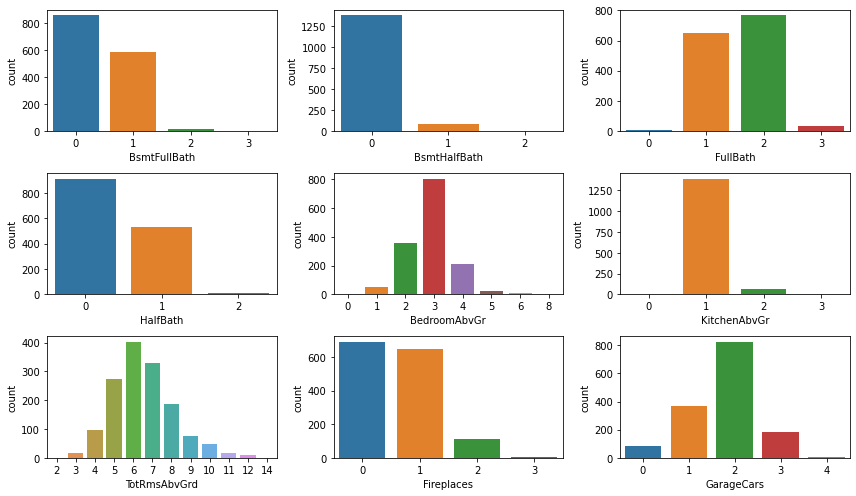

In [14]:
fig = plt.figure(figsize=(12, 7))
n_rows = 3
n_cols = 3

for i in range(n_rows*n_cols):
  fig.add_subplot(n_rows, n_cols, i+1)
  sns.countplot(x=dis_cols[i], data=train_df)

fig.tight_layout()
plt.show();

- `BsmtFullBath` (Basement full bathrooms): Most properties have one or no bathroom in the basement.
- `BsmtHalfBath` (Basement half bathrooms): Most properties have no half bathroom in the basement.
- `FullBath` (Full bathrooms above grade): Almost all buildings have one or two bathrooms above the ground.
- `HalfBath` (Half baths above grade): Most properties have one or no bathroom above the ground.
- `BedroomAbvGr` (Bedrooms above grade; does not include basement bedrooms): Many houses have three bedrooms above grade.
- `KitchenAbvGr` (Kitchens above grade): Almost all properties have only one kitchen.
- `TotRmsAbvGrd` (Total rooms above grade; does not include bathrooms): Most buildings have about five to sevem rooms above the ground level. Would the sum of `BedroomAbvGr` and `KitchenAbrGr` be `TotRmsAbvGrd`?
- `Fireplaces` (Number of fireplaces): The majority of the properties have one or no fireplace.
- `GarageCars` (Size of garage in car capacity): Most properties have a garage that can accommodate two cars.



### 2.1.2 Continuous variables

First, let's have a look at the target variable, `SalePrice`, which is also continuous.

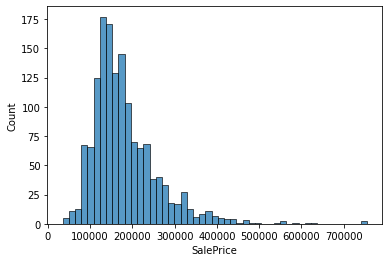

In [15]:
sns.histplot(data=train_df, x='SalePrice');

The distribution does not seem normal but right skewed.

In [16]:
pd.set_option('display.max_columns', None)
train_df[con_cols].describe()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice
count,1201.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,70.049958,10516.828082,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,180921.195890
std,24.284752,9981.264932,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,79442.502883
min,21.000000,1300.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34900.000000
25%,59.000000,7553.500000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,129975.000000
50%,69.000000,9478.500000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,163000.000000
75%,80.000000,11601.500000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,214000.000000
max,313.000000,215245.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,755000.000000


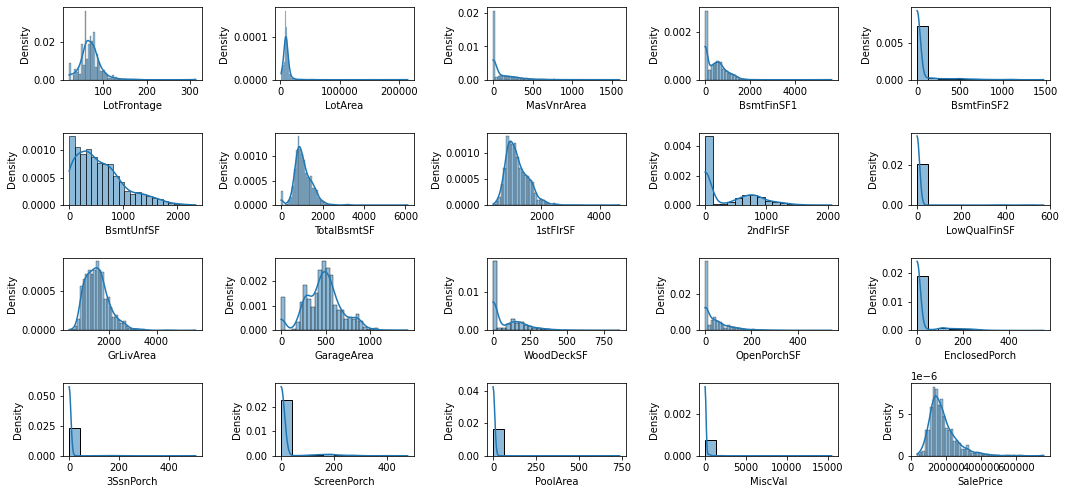

In [17]:
# create the figure and axes
fig, axes = plt.subplots(4, 5, figsize=(15, 7))
axes = axes.ravel()

for col, ax in zip(con_cols, axes):
  sns.histplot(data=train_df[col], kde=True, stat='density', ax=ax)

fig.tight_layout()
plt.show();

- Many of the continuous features are right skewed.
- We can apply logarithmic transformation on them to make less skewed or even normal.

## 2.2 Categorical Variables

In [18]:
# change data type of `MSSubClass`, `OverallQual` and `OverallCond`
train_df['MSSubClass'] = train_df['MSSubClass'].astype('O')
train_df['OverallQual'] = train_df['OverallQual'].astype('O')
train_df['OverallCond'] = train_df['OverallCond'].astype('O')

test_df_no_id['MSSubClass'] = test_df_no_id['MSSubClass'].astype('O')
test_df_no_id['OverallQual'] = test_df_no_id['OverallQual'].astype('O')
test_df_no_id['OverallCond'] = test_df_no_id['OverallCond'].astype('O')

In [19]:
train_df[cat_cols].describe(exclude=np.number)

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,MSSubClass,OverallQual,OverallCond
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1452,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1459,1460,1460,770,1379,1379,1379,1379,1460,7,281,54,1460,1460,1460,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,4,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6,15,10,9
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal,20,5,5
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,864,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735,1360,380,870,605,1311,1326,1340,3,157,49,1267,1198,536,397,821


# 3. Data Exploration - Multivariate

Now we examine the relationship between the variables and the target variable, `SalePrice`.



## 3.1 Numerical variables

### 3.1.1 Discrete variables

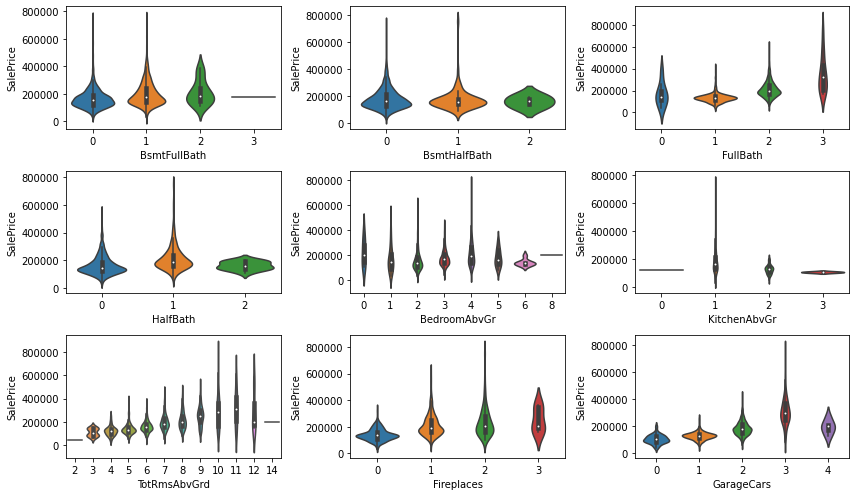

In [20]:
# create the figure and axes
fig, axes = plt.subplots(3, 3, figsize=(12, 7))
axes = axes.ravel()

for col, ax in zip(dis_cols, axes):
  sns.violinplot(data=train_df, x=col, y='SalePrice', ax=ax)

fig.tight_layout()
plt.show();

- The number of either half or full bathrooms in the basement does not seem to have much relationship with `SalePrice`.
- The same can be concluded with `HalfBath`.
- The more full bathrooms a property has above the ground level represented by `FullBath`, the higher the sale price is.
- The same happens when there are more rooms above the ground, fireplaces, or cars that can be parked in garage.
- No specific pattern is detected with the rest of the discrete variables (`BedroomAbvGr`, and `KitchenAbvGr`).

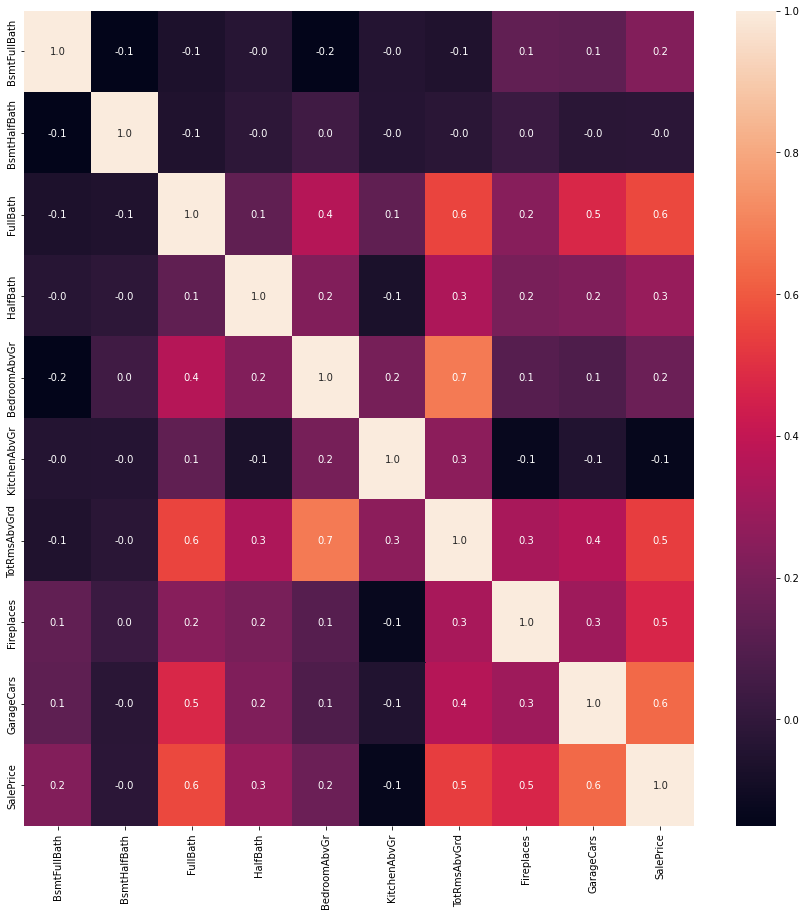

In [21]:
fig = plt.figure(figsize=(15, 15))

dis_cols.append('SalePrice')
sns.heatmap(train_df[dis_cols].corr(), annot=True, fmt=".1f")
plt.show();

dis_cols.remove('SalePrice')

- The conclusions that we have made above can also be derived from this correlation matrix.
  - `SalePrice` are positively correlated with `FullBath`, `TotRmsAbvGrd`, `Fireplaces`, and `GarageCars`.
- There are positive correlations among `TotRmsAbvGrd`, `FullBath` and `BedroomAbvGr`.
  - This seems obvious as if there are more bedrooms above ground, there are also more total rooms and more full bathroms.
  - However, `TotRmsAbvGrd` does not take into account the number of full bathrooms.
  - Thus, we may delete `BedRoomAbvGr` and leave the other two variables as it has the least correlation with the dependent variable.

### 3.1.2 Continuous variables

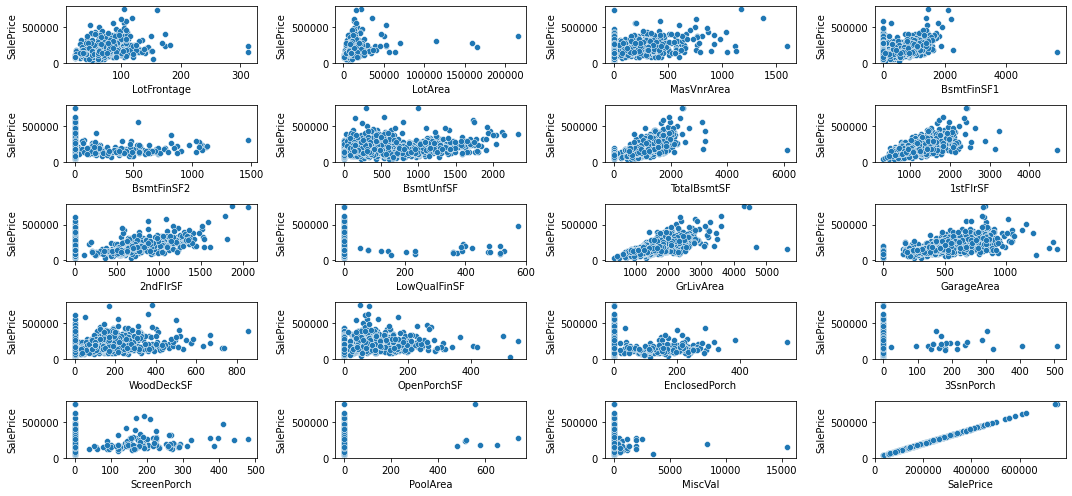

In [22]:
# create the figure and axes
fig, axes = plt.subplots(5, 4, figsize=(15, 7))
axes = axes.ravel()

for col, ax in zip(con_cols, axes):
  sns.scatterplot(data=train_df, x=col, y='SalePrice', ax=ax)

fig.tight_layout()
plt.show();

- There are positive relationships between `SalePrice` and `LotFrontage`, and between `SalePrice` and `LotArea`.
- We also detect a positive relationship between the target and `TotalBsmtSF`.
  - The sum of `BsmtFinSF1`, `BsmtFinSF2` and `BsmtUnfSF` equals `TotalBsmtSF`.
  - This is an example of perfect multicollinearity. Thus, we will have to drop one of the four variable.
- The same happens to the features related to the size of above ground floors.
  - `GrLivArea` is equal to the sum of `1stFlrSF`, `2ndFlrSF`, and `LowQualFinSF`.
- No specific patterns are not seen between the sale price and features associated with porch size.

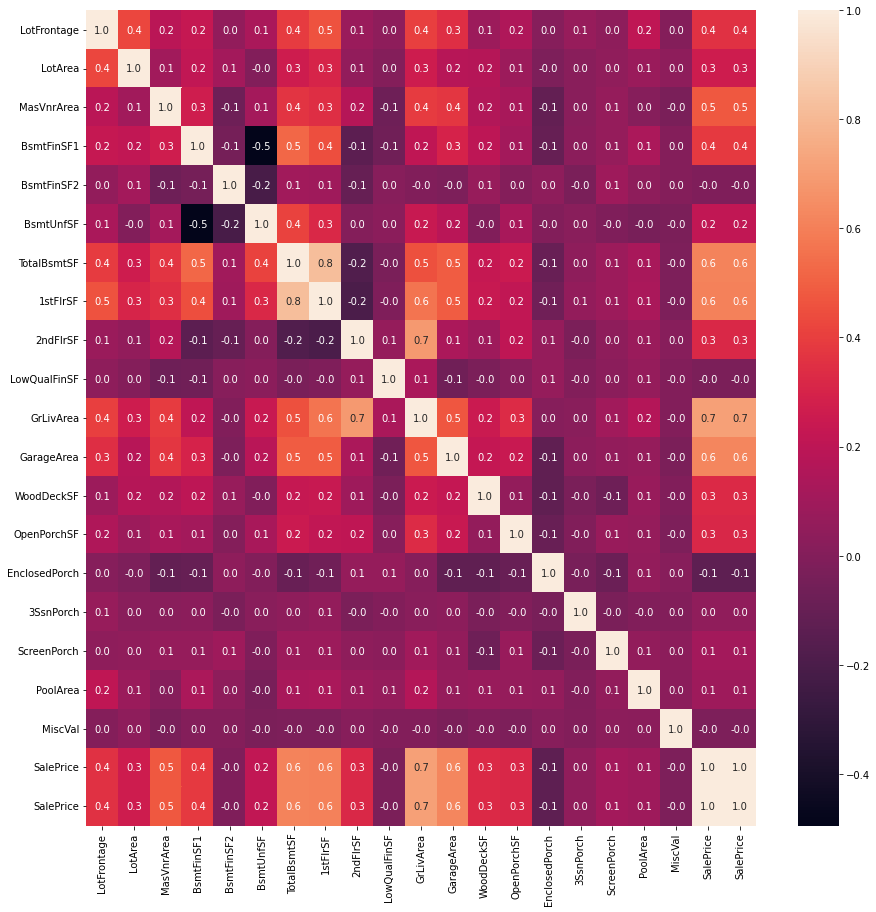

In [23]:
fig = plt.figure(figsize=(15, 15))

con_cols.append('SalePrice')
sns.heatmap(train_df[con_cols].corr(), annot=True, fmt=".1f")
plt.show();

con_cols.remove('SalePrice')

- There is positive correlaton between `SalePrice` and some predictors like `MasVnrArea`, `TotalBsmtSF`, `1stFlrSF`, and `GrLivArea`.
  - In general, the bigger area a property has, the higher its sale price is. 
  - Are these predictors correlated positively?
    - Yes, because they represent property size. 
    - For example. `TotalBsmtSF` and `1stFlrSF` have a correlation of 0.8.

In [24]:
train_df.drop(['BsmtFinSF2', 'LowQualFinSF'], axis=1, inplace=True)
test_df_no_id.drop(['BsmtFinSF2', 'LowQualFinSF'], axis=1, inplace=True)

### 3.1.3 Time variables

Before we dive into the categorical variables, we will explore the relationship between each time variable and the dependent variable.

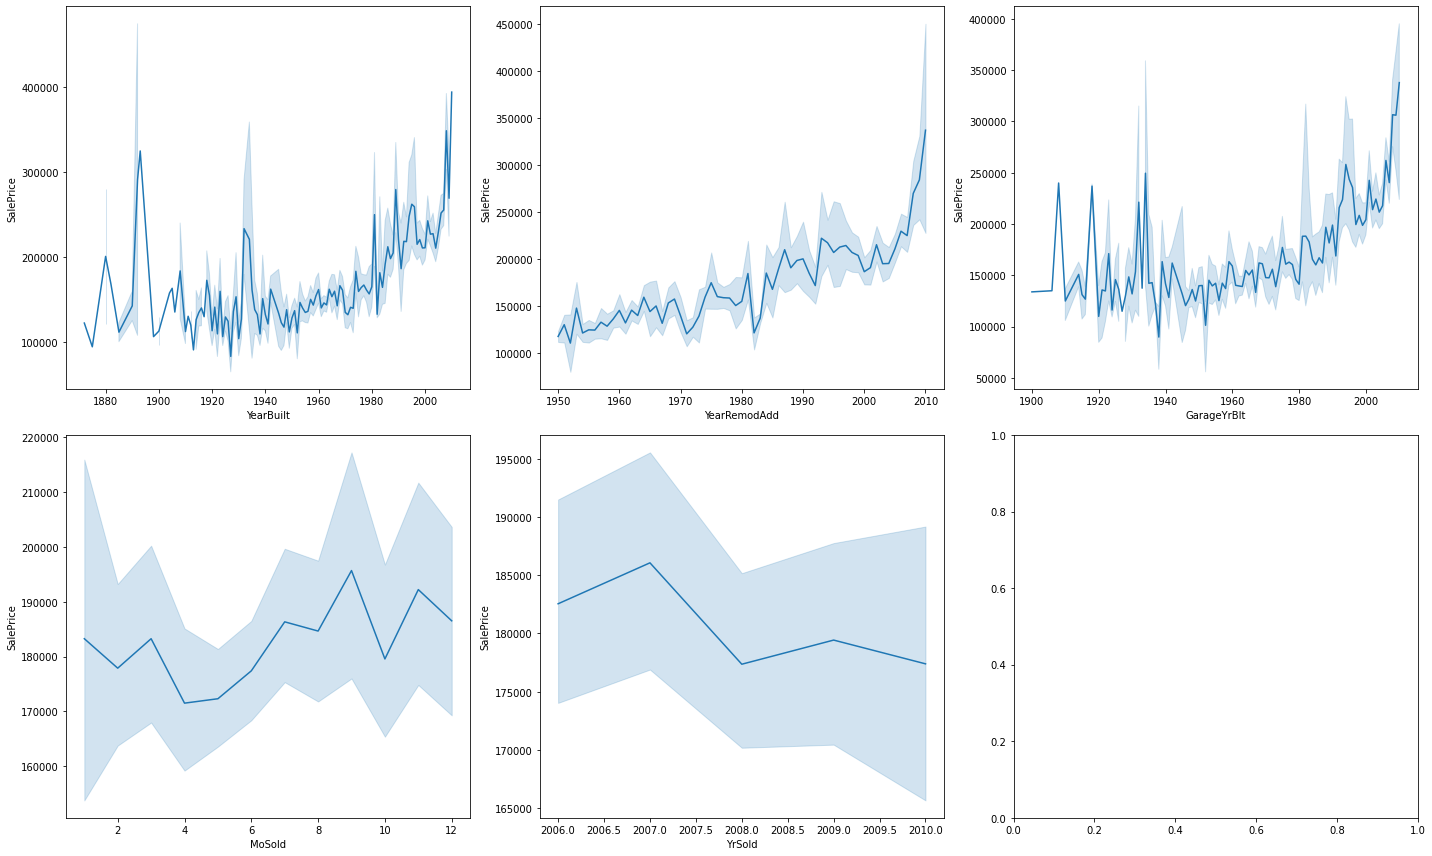

In [25]:
n_rows = 2
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 12))
axes = axes.ravel()

for col, ax in zip(time_cols, axes):
  sns.lineplot(x=col, y='SalePrice', data=train_df, ax=ax)

fig.tight_layout()
plt.show();

The plots above indicate that the more recent a house is built or remodeled, the higher its price is. 

## 3.2 Categorical variables

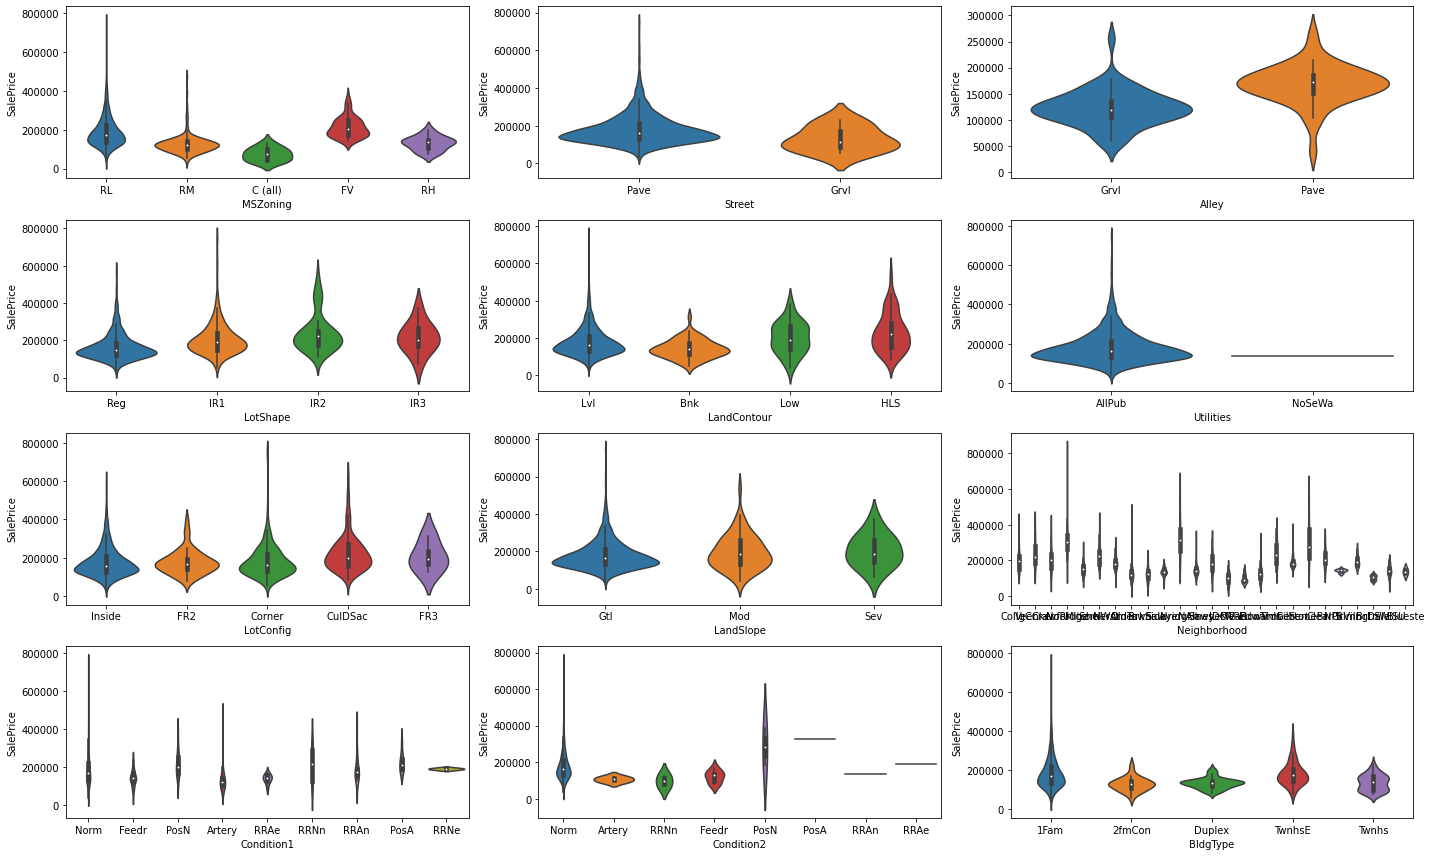

In [26]:
n_rows = 4
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 12))
axes = axes.ravel()

for col, ax in zip(cat_cols[:n_rows*n_cols], axes):
  sns.violinplot(data=train_df, x=col, y='SalePrice', ax=ax)

fig.tight_layout()
plt.show();

- Paved alley access to property adds more value to sale price.
- Properties located near positive off-site feature--park, greenbelt, etc. have a higher median sale price.

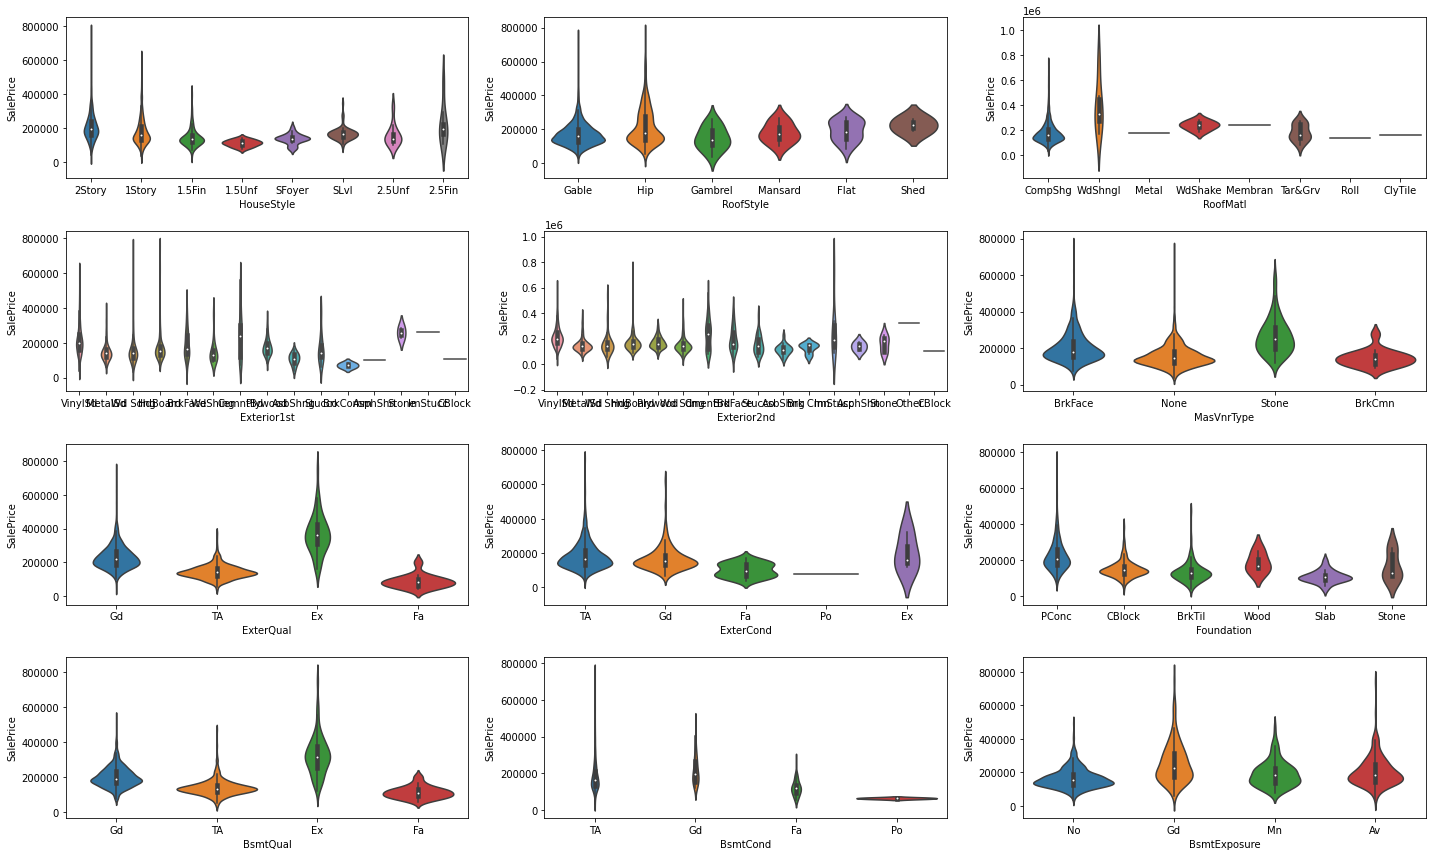

In [27]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 12))
axes = axes.ravel()

for col, ax in zip(cat_cols[n_rows*n_cols:n_rows*n_cols*2], axes):
  sns.violinplot(data=train_df, x=col, y='SalePrice', ax=ax)

fig.tight_layout()
plt.show();

- `HouseStyle`: Unfinished properties tend to have a bit lower sale price.
- `ExterQual` (the quality of the material on the exterior) and `BsmtQual` (the height of the basement) have positive impact on the sale price.
- Houses with stone masonary veneer type (`MasVnrType`) are more likely to be costly than those with the other types.
- If a property has an excellent quality of the material on the exterior or if the height of the property is more than 100 inches, it's more expensive.

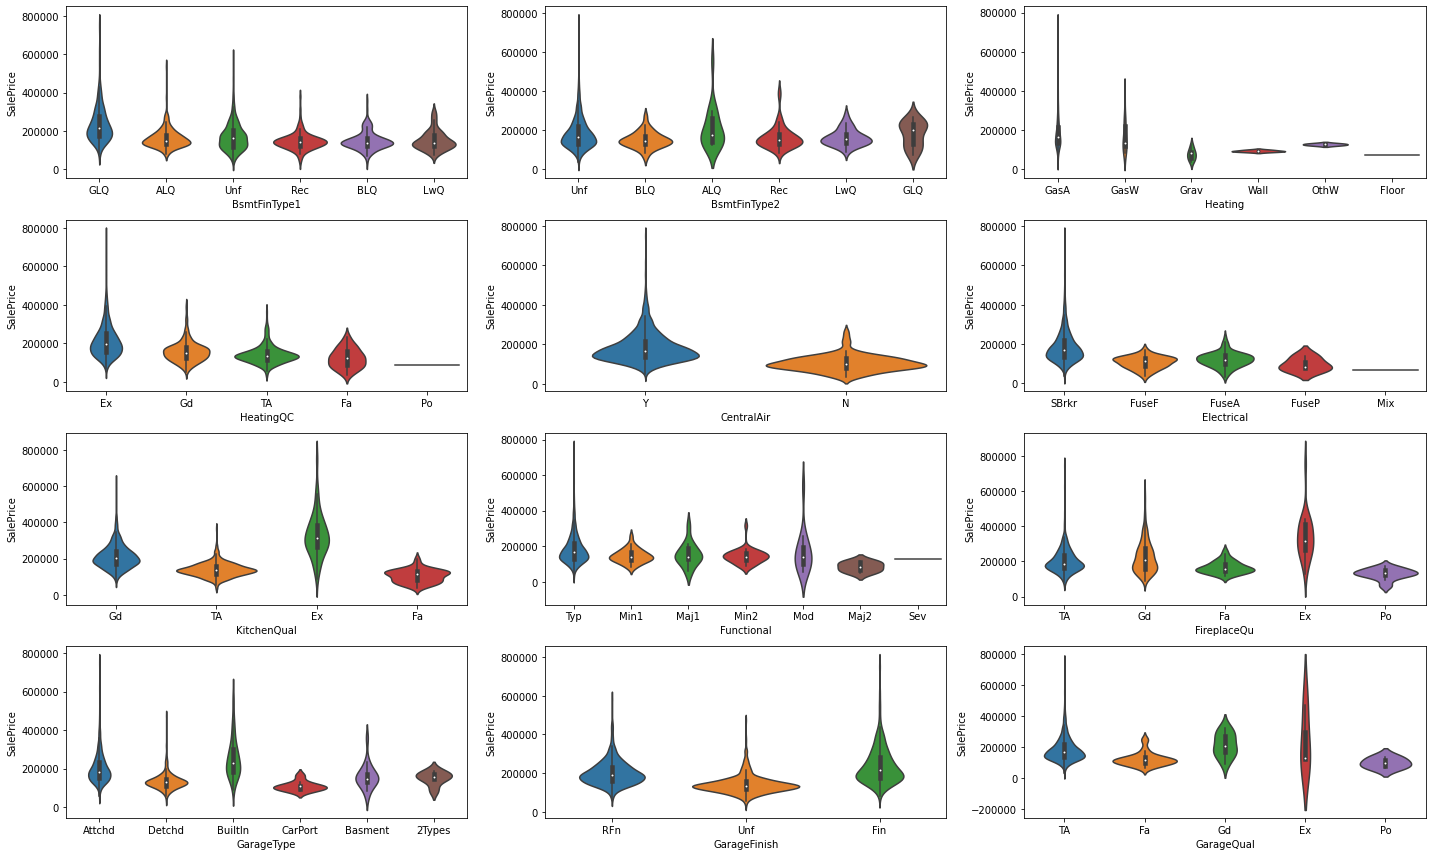

In [28]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 12))
axes = axes.ravel()

for col, ax in zip(cat_cols[n_rows*n_cols*2:n_rows*n_cols*3], axes):
  sns.violinplot(data=train_df, x=col, y='SalePrice', ax=ax)

fig.tight_layout()
plt.show();

- The qualities of heating, kitchen and fireplace tend to have a positive impact on sale price.

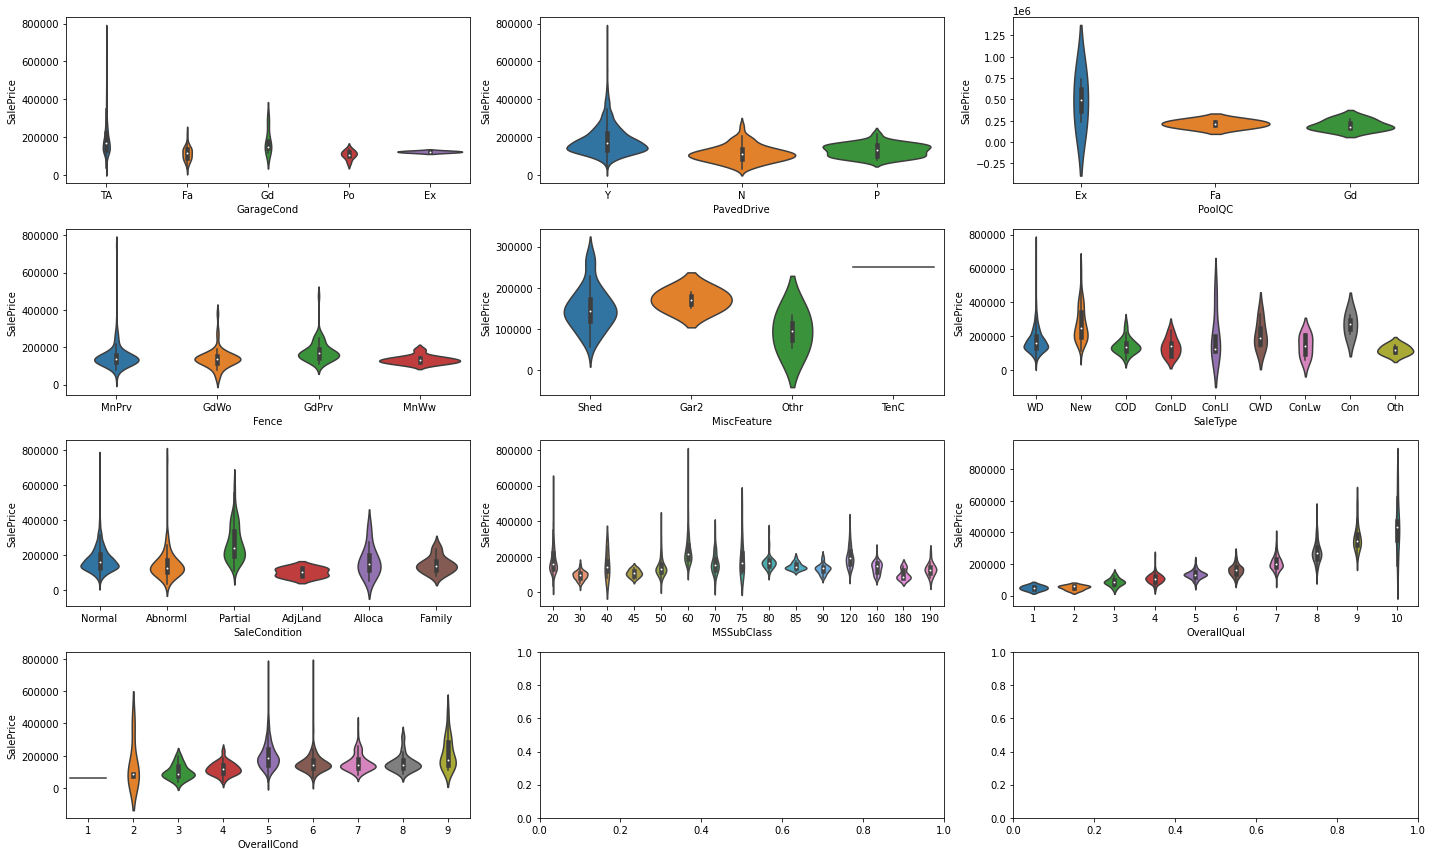

In [29]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 12))
axes = axes.ravel()

for col, ax in zip(cat_cols[n_rows*n_cols*3:n_rows*n_cols*4], axes):
  sns.violinplot(data=train_df, x=col, y='SalePrice', ax=ax)

fig.tight_layout()
plt.show();

- It seems obvious that the better the overall condition of a house is, the higher the median sale price is.

# 4. Missingness

## 4.1 LotFrontage

The first feature to investigate is `LotFrontage` and we will examine other features related to real estate lot to see if they are useful for imputing missing values of this variable.

In [30]:
lot_features = [col for col in train_df.columns if 'Lot' in col]
lot_features

['LotFrontage', 'LotArea', 'LotShape', 'LotConfig']

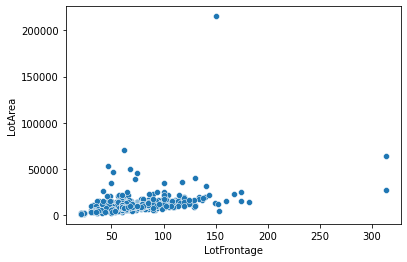

In [31]:
sns.scatterplot(data=train_df, x='LotFrontage', y='LotArea');

It seems that there is no noticeable relationship between `LotFrontage` and `LotArea`. We also see that there are some outliers.

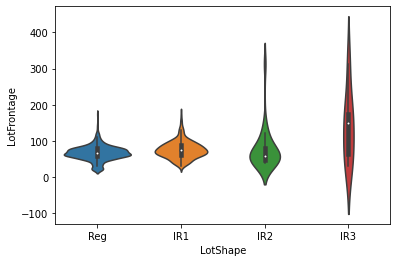

In [32]:
sns.violinplot(data=train_df, x='LotShape', y='LotFrontage');

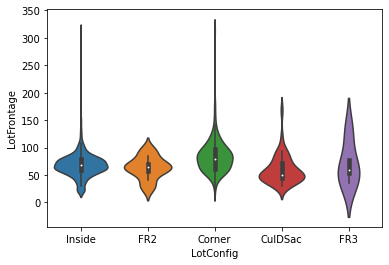

In [33]:
sns.violinplot(data=train_df, x='LotConfig', y='LotFrontage');

The other two categorical variables, `LotShape` and `LotConfig`, have no special relationship with `LotFrontage`. Thus, we will impute the missing values by the median value of the feature.

In [34]:
con_cols.remove('BsmtFinSF2')
con_cols.remove('LowQualFinSF')
con_cols.remove('SalePrice')

## 4.2 Garage

Now let's examine the features related to garage.

In [35]:
garage_features = [col for col in train_df.columns if 'Garage' in col]
garage_features

['GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond']

In [36]:
train_df[garage_features].isna().sum()

GarageType      81
GarageYrBlt     81
GarageFinish    81
GarageCars       0
GarageArea       0
GarageQual      81
GarageCond      81
dtype: int64

In [37]:
test_df_no_id[garage_features].isna().sum()

GarageType      76
GarageYrBlt     78
GarageFinish    78
GarageCars       1
GarageArea       1
GarageQual      78
GarageCond      78
dtype: int64

In [38]:
train_df.loc[train_df['GarageType'].isna(), garage_features]

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
39,NaN,NaN,NaN,0,0,NaN,NaN
48,NaN,NaN,NaN,0,0,NaN,NaN
78,NaN,NaN,NaN,0,0,NaN,NaN
88,NaN,NaN,NaN,0,0,NaN,NaN
89,NaN,NaN,NaN,0,0,NaN,NaN
...,...,...,...,...,...,...,...
1349,NaN,NaN,NaN,0,0,NaN,NaN
1407,NaN,NaN,NaN,0,0,NaN,NaN
1449,NaN,NaN,NaN,0,0,NaN,NaN
1450,NaN,NaN,NaN,0,0,NaN,NaN


It can be seen that properties with no garage have zero car capacity and zero square feet. Therefore, `NaN` values cannot be considered as missing but should be replaced into another value to avoid confusion.

In [39]:
train_df['GarageYrBlt'] = train_df['GarageYrBlt'].fillna(9999)
test_df_no_id['GarageYrBlt'] = test_df_no_id['GarageYrBlt'].fillna(9999)
garage_features.remove('GarageYrBlt')
train_df[garage_features] = train_df[garage_features].fillna('NoGarage')
garage_features.remove('GarageCars')
garage_features.remove('GarageArea')
test_df_no_id[garage_features] = test_df_no_id[garage_features].fillna('NoGarage')

## 4.3 Basement

In [40]:
bsmt_features = [col for col in train_df.columns if 'Bsmt' in col]
bsmt_features

['BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath']

In [41]:
train_df[bsmt_features].isna().sum()

BsmtQual        37
BsmtCond        37
BsmtExposure    38
BsmtFinType1    37
BsmtFinSF1       0
BsmtFinType2    38
BsmtUnfSF        0
TotalBsmtSF      0
BsmtFullBath     0
BsmtHalfBath     0
dtype: int64

In [42]:
test_df_no_id[bsmt_features].isna().sum()

BsmtQual        44
BsmtCond        45
BsmtExposure    44
BsmtFinType1    42
BsmtFinSF1       1
BsmtFinType2    42
BsmtUnfSF        1
TotalBsmtSF      1
BsmtFullBath     2
BsmtHalfBath     2
dtype: int64

In [43]:
train_df.loc[(train_df['BsmtExposure'].isna()) | (train_df['BsmtFinType2'].isna()), bsmt_features]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
17,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0
39,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0
90,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0
102,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0
156,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0
182,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0
259,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0
332,Gd,TA,No,GLQ,1124,NaN,1603,3206,1,0
342,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0
362,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0


The same logic applies here but there is two rows where `BsmtExposure` or `BsmtFinType2` is missing but the others are not.

In [44]:
train_df.loc[(train_df['BsmtExposure'].isna()) & (train_df['BsmtCond'].isna()==False), bsmt_features]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
948,Gd,TA,NaN,Unf,0,Unf,936,936,0,0


In [45]:
train_df.loc[(train_df['BsmtQual']=='Gd') & (train_df['BsmtCond']=='TA') & (train_df['BsmtFinType1']=='Unf') & (train_df['BsmtFinType2']=='Unf'), bsmt_features]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
13,Gd,TA,Av,Unf,0,Unf,1494,1494,0,0
22,Gd,TA,No,Unf,0,Unf,1777,1777,0,0
25,Gd,TA,No,Unf,0,Unf,1566,1566,0,0
36,Gd,TA,No,Unf,0,Unf,1097,1097,0,0
57,Gd,TA,No,Unf,0,Unf,860,860,0,0
...,...,...,...,...,...,...,...,...,...,...
1444,Gd,TA,Av,Unf,0,Unf,1422,1422,0,0
1450,Gd,TA,No,Unf,0,Unf,896,896,0,0
1451,Gd,TA,No,Unf,0,Unf,1573,1573,0,0
1453,Gd,TA,No,Unf,0,Unf,1140,1140,0,0


Examining observations where the values of the features related to the garage are equal to those of the 948th observation, except for `BsmtExposure`, we can conclude that the missing value in `BsmtExposure` for that row must have been erroneously recorded. 

Now, let's examine the row whose `BsmtFinType2` is missing.

In [46]:
train_df.loc[(train_df['BsmtFinType2'].isna()) & (train_df['BsmtCond'].isna()==False), bsmt_features]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
332,Gd,TA,No,GLQ,1124,NaN,1603,3206,1,0


Notice that `BsmtFinSF2` is greater than 0 even though BsmtFinType2 is missing (i.e. there is no basement in the property). So, as before, we can infer that value was entered incorrectly. Consequently, we will replace the missing values of the columns into another value apart from the 948th observation.

In [47]:
# replace NaN to `NoBsmt`
train_df.loc[train_df.index != 948, bsmt_features] = train_df.loc[train_df.index != 948, bsmt_features].fillna('NoBsmt')

bsmt_features.remove('BsmtFinSF1')
bsmt_features.remove('BsmtUnfSF')
bsmt_features.remove('TotalBsmtSF')
bsmt_features.remove('BsmtFullBath')
bsmt_features.remove('BsmtHalfBath')

test_df_no_id[bsmt_features] = test_df_no_id[bsmt_features].fillna('NoBsmt') 

## 4.4 Fireplace

In [48]:
fireplace_features = [col for col in train_df.columns if 'Fireplace' in col]
fireplace_features

['Fireplaces', 'FireplaceQu']

In [49]:
train_df.loc[train_df['FireplaceQu'].isna(), fireplace_features]

,Fireplaces,FireplaceQu
0,0,NaN
5,0,NaN
10,0,NaN
12,0,NaN
15,0,NaN
...,...,...
1452,0,NaN
1453,0,NaN
1454,0,NaN
1458,0,NaN


In [50]:
test_df_no_id.loc[test_df_no_id['FireplaceQu'].isna(), fireplace_features]

,Fireplaces,FireplaceQu
0,0,NaN
1,0,NaN
4,0,NaN
6,0,NaN
9,0,NaN
...,...,...
1452,0,NaN
1453,0,NaN
1454,0,NaN
1455,0,NaN


In [51]:
train_df.loc[train_df['FireplaceQu'].isna(), 'Fireplaces'].sum()

0

In [52]:
train_df.loc[train_df['Fireplaces']==0, 'FireplaceQu'].value_counts()

Series([], Name: FireplaceQu, dtype: int64)

When it comes to the missing values in `FireplaceQu`, houses which do not have fireplaces have `FireplaceQu`. Consequently, as we did before, we will just replace `NaN` into `NoFireplace`.

In [53]:
train_df['FireplaceQu'] = train_df['FireplaceQu'].fillna('NoFireplace')
test_df_no_id['FireplaceQu'] = test_df_no_id['FireplaceQu'].fillna('NoFireplace')

## 4.5 Pool

In [54]:
pool_features = [col for col in train_df.columns if 'Pool' in col]
pool_features

['PoolArea', 'PoolQC']

In [55]:
train_df.loc[train_df['PoolQC'].isna(), pool_features]

,PoolArea,PoolQC
0,0,NaN
1,0,NaN
2,0,NaN
3,0,NaN
4,0,NaN
...,...,...
1455,0,NaN
1456,0,NaN
1457,0,NaN
1458,0,NaN


In [56]:
train_df.loc[train_df['PoolQC'].isna(), 'PoolArea'].sum()

0

Here we do the same thing we did for `FireplaceQu`. Houses that do not own a pool have `PoolArea` equal to 0. Therefore, 'NaN' values are replaced with 'NoPool'.

In [57]:
train_df['PoolQC'] = train_df['PoolQC'].fillna('NoPool')
test_df_no_id['PoolQC'] = test_df_no_id['PoolQC'].fillna('NoPool')

## 4.6 Alley, Fence, and MiscFeature

Regarding these features, as you can see in the data description, 'NaN' means no alley, no fence, and other features not covered by the other categories, respectively. So we simply replace missing values with `NoAlley`, `NoFence` and `None`.

In [58]:
train_df['Alley'] = train_df['Alley'].fillna('NoAlley')
train_df['Fence'] = train_df['Fence'].fillna('NoFence')
train_df['MiscFeature'] = train_df['MiscFeature'].fillna('None')

test_df_no_id['Alley'] = test_df_no_id['Alley'].fillna('NoAlley')
test_df_no_id['Fence'] = test_df_no_id['Fence'].fillna('NoFence')
test_df_no_id['MiscFeature'] = test_df_no_id['MiscFeature'].fillna('None')

## 4.7 MasVnrType, and MasVnrArea

It seems that there are no additional information that we can use to make inference about the missingness in these columns. Therefore, we will use `SimpleImputer` from sklearn and complete the missing values with the most frequent value along each column.

In [59]:
train_df.isna().sum()[train_df.isna().sum()>0]

LotFrontage     259
MasVnrType        8
MasVnrArea        8
BsmtExposure      1
Electrical        1
dtype: int64

In [60]:
test_df_no_id.isna().sum()[test_df_no_id.isna().sum()>0]

MSZoning          4
LotFrontage     227
Utilities         2
Exterior1st       1
Exterior2nd       1
MasVnrType       16
MasVnrArea       15
BsmtFinSF1        1
BsmtUnfSF         1
TotalBsmtSF       1
BsmtFullBath      2
BsmtHalfBath      2
KitchenQual       1
Functional        2
GarageCars        1
GarageArea        1
SaleType          1
dtype: int64

## 4.8 Electrical

We apply the same imputer to `Electrical` column as we have only one missing value.

In [61]:
imp_median = SimpleImputer(strategy='median')
imp_mode = SimpleImputer(strategy='most_frequent')

imp_median.fit(train_df[con_cols])
imp_mode.fit(train_df[dis_cols+cat_cols])

train_df[con_cols] = imp_median.transform(train_df[con_cols])
test_df_no_id[con_cols] = imp_median.transform(test_df_no_id[con_cols])
train_df[dis_cols+cat_cols] = imp_mode.transform(train_df[dis_cols+cat_cols])
test_df_no_id[dis_cols+cat_cols] = imp_mode.transform(test_df_no_id[dis_cols+cat_cols])

In [62]:
train_df.isna().sum()[train_df.isna().sum()>0]

Series([], dtype: int64)

In [63]:
test_df_no_id.isna().sum()[test_df_no_id.isna().sum()>0]

Series([], dtype: int64)

# 5. Outlier Detection

In this section, we will detect possible outliers. First, we have to convert the categorical variables into as one-hot numeric arrays.

In [64]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')

ohe_df = pd.DataFrame(enc.fit_transform(train_df[cat_cols]).toarray(), columns=enc.get_feature_names_out(), index=train_df.index)

In [65]:
train_df_ohe = train_df.drop(labels=cat_cols, axis=1)
train_df_ohe = pd.concat([train_df_ohe, ohe_df], axis=1)

In [66]:
train_df_ohe.shape

(1460, 332)

The resulting data frame has 332 columns as the encoder generates a binary column for each categorical level. The data is now ready for outlier detection. The algorithm we will be using is an isolated forest. It is an ensemble method that gives each observation an anomaly score averaged over the predictions of multiple decision trees.

To construct a decision tree, a random value of a random feature is selected at each split until every leaf in the tree represents a single data point in the data set. In general, an outlier tends to be isolated at a smaller tree depth than other data points. We then assign an anomaly to each observation by aggregating the depth obtained from the decision trees. We give -1 for outliers and 1 for inliers.

Source - [Isolation Forest](https://medium.com/@corymaklin/isolation-forest-799fceacdda4)

In [67]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(random_state=42)
train_df_ohe['anomaly_score'] = clf.fit_predict(train_df_ohe)

In [68]:
if train_df_ohe[train_df_ohe['anomaly_score']==1].shape[0] == train_df_ohe.shape[0]:
  print("There are no outliers detected.")
else:
  print(f"{train_df_ohe.shape[0]-train_df_ohe[train_df_ohe['anomaly_score']==1].shape[0]} outliers are identified.")

8 outliers are identified.


As we can see, 8 anomalies were detected using the isolated forest algorithm. There aren't that many, so we drop those observations.

In [69]:
# drop anomalous observations
train_df_ohe.drop(labels=train_df_ohe[train_df_ohe['anomaly_score']==-1].index.tolist(), axis=0, inplace=True)

# drop anomay_score column
train_df_ohe.drop(labels='anomaly_score', axis=1, inplace=True)

In [70]:
train_df_ohe.shape

(1452, 332)

# 6. Feature Selection and Modeling

Since there are over 300 features, we are going to try different algorithms (Lasso and random forest) to select features that are more important than others in predicting the target variable. Feature selection provides the following benefits:
- Our predictive model may train faster, 
- A good subset of features selected can improve model performance.
- Overfitting is avoided.

Check out this [post](https://www.analyticsvidhya.com/blog/2016/12/introduction-to-feature-selection-methods-with-an-example-or-how-to-select-the-right-variables/) by Analytics Vidhya for more information on feature selection.

## 6.1 Lasso Regression

Lasso regression is one of the popular algorithms of embedded methods with built-in feature selection methods. It is a linear model that performs L1 regularization by minimizing the cost function while penalizing the magnitude of the feature coefficients. The value of the hyperparameter controlling the strength of the penalty is found through cross-validation.

To see how it works, let's first split the training data into the predictors denoted as $X$ and the dependent variable, $y$.





In [71]:
# split the data into X (predictors) and y (target)
X_lasso = train_df_ohe.drop(labels='SalePrice', axis=1)
y_lasso = train_df_ohe['SalePrice']
X_lasso.shape, y_lasso.shape

((1452, 331), (1452,))

Then, we split $X$ and $y$ into random training and testing subsets. The test subsets have about one third of the total observations.

In [72]:
# split X and y into random train and test subsets
X_train_lasso, X_test_lasso, y_train_lasso, y_test_lasso = train_test_split(X_lasso, y_lasso, test_size=0.33, random_state=42)

Next, we create a pipeline which sequentially apply a list of transformations and a final estimator. The training data is first standardized by demeaning and scaling to unit variance. Standardization is necessary because the larger the variance of a variable, the smaller the coefficient, so there is less penalty for that variable. Finally, we fit the data using lasso regression model.

Source - [Built in](https://builtin.com/data-science/when-and-why-standardize-your-data), [Stack Exchange](https://stats.stackexchange.com/questions/69568/whether-to-rescale-indicator-binary-dummy-predictors-for-lasso)

In [73]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(tol=0.01))
])

We then create an object that performs a search for the optimal value of a hyperparameter called alpha for the lasso model. The hyperparameter is optimized by 5 cross-validated grid-search over a sequence of 100 random numbers from a uniform distribution is evaluated. The value that produces the smallest mean squared error regression loss is then selected as the optimal alpha.

In [74]:
search_lasso = RandomizedSearchCV(
    estimator=pipeline, 
    param_distributions={'lasso__alpha': uniform.rvs(loc=0, scale=10, size=100, random_state=42)},
    cv=5,
    scoring="neg_mean_squared_error"
)

In [75]:
search_lasso.fit(X_train_lasso, y_train_lasso)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.779e+10, tolerance: 4.598e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.948e+10, tolerance: 4.947e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.126e+11, tolerance: 5.214e+10

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('lasso', Lasso(tol=0.01))]),
                   param_distributions={'lasso__alpha': array([3.74540119, 9.50714306, 7.31993942, 5.98658484, 1.5601864 ,
       1.5599452 , 0.58083612, 8.66176146, 6.01115012, 7.08072578,
       0.20584494, 9.69909852, 8.32442641, 2.12339111, 1.81824967,
       1.8340451 , 3.04242243, 5.24756432, 4.3194...
       7.72244769, 1.98715682, 0.05522117, 8.15461428, 7.06857344,
       7.29007168, 7.71270347, 0.74044652, 3.58465729, 1.1586906 ,
       8.63103426, 6.23298127, 3.30898025, 0.6355835 , 3.10982322,
       3.25183322, 7.29606178, 6.37557471, 8.87212743, 4.72214925,
       1.19594246, 7.13244787, 7.60785049, 5.61277198, 7.7096718 ,
       4.93795596, 5.22732829, 4.27541018, 0.25419127, 1.07891427])},
                   scoring='neg_mean_squared_error')

In [76]:
search_lasso.best_params_

{'lasso__alpha': 9.093204020787821}

The optimal value of the hyperparameter was found to be around 9.4. With this value in mind, let's look at the resulting slope coefficients and see their importance.

In [77]:
coefficients = search_lasso.best_estimator_.named_steps['lasso'].coef_

importance = np.abs(coefficients)
print(f"There are {len(X_train_lasso.columns[importance == 0])} features that did not help predict the sale price.")

There are 44 features that did not help predict the sale price.


In [78]:
pd.Series(importance, index=X_lasso.columns).sort_values(ascending=False)[:5]

2ndFlrSF               25721.269758
1stFlrSF               14783.664328
YearBuilt              12022.023519
TotalBsmtSF            10394.678675
Exterior1st_CemntBd    10067.736415
dtype: float64

The five most important features are those shown above. The features that inform the size of the house can be seen as useful in predicting the sale price. We also see that the date of construction and the material covering the house are given importance.

Note that when we encoded the categorical features as a one-hot numeric array. we did not drop one of the levels per feature. It is because predictions can vary depending on which columns are omitted. 

Source - [Stack Exchange](https://stats.stackexchange.com/questions/231285/dropping-one-of-the-columns-when-using-one-hot-encoding).

In [79]:
y_preds_lasso = search_lasso.best_estimator_.predict(X_test_lasso)
print(f"The error on the testing data is {np.sqrt(mean_squared_error(np.log(y_test_lasso), np.log(y_preds_lasso)))}.")

The error on the testing data is 0.1513874638888274.


## 6.2 Random Forest

The next algorithm we will try is the random forest regressor. Similar to the Lasso regression model, it is an embedded method with a built-in model selection process. 

Before looking at how important each feature is, we are going to encode the categorical variables first because sklearn models can handle only numerical data. However, unlike what we did for the Lasso regression model, we will use mean encoding. If we opted for one hot encoding as before, the algorithm would perform worse due to high cardinality. Similarly, because the categories are unordered, it doesn't make sense to use a label encoding that encodes the target label as a value between 0 and the number of categories minus 1. Therefore, we group the data by each distinct value of the categorical feature and compute the average of the dependent variable, which are encoding values.

Source - [One Hot encoding](https://towardsdatascience.com/one-hot-encoding-is-making-your-tree-based-ensembles-worse-heres-why-d64b282b5769), [Mean encoding](https://towardsdatascience.com/why-you-should-try-mean-encoding-17057262cd0)

In [80]:
train_df_rf = train_df.copy()
# mean encoding
for col in cat_cols:
  level_mean = train_df.groupby(col)['SalePrice'].mean()
  train_df_rf[col] = train_df_rf[col].map(level_mean)

The result of the mean encoding is as follows.

In [81]:
train_df_rf[cat_cols].head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,MSSubClass,OverallQual,OverallCond
0,191004.994787,181130.538514,183452.131483,164754.818378,180183.746758,180950.95682,176938.047529,179956.799566,197965.773333,184495.492063,181169.405536,185763.807377,210051.764045,171483.956179,179803.679219,213732.900971,214432.460317,204691.871910,231633.510246,184034.896256,225230.442040,202688.478964,183632.620900,165680.438155,235413.720096,184694.690287,182021.195378,214914.429150,186186.70989,186810.637453,212116.023891,183429.147059,141331.482609,202892.656322,202068.869668,187489.836003,187885.735294,186433.973881,180404.663455,187596.837998,182046.410384,173401.836622,175202.219533,239948.501672,207716.423197,203146.914738
1,191004.994787,181130.538514,183452.131483,164754.818378,180183.746758,180950.95682,177934.574468,179956.799566,238772.727273,142475.481481,181169.405536,185763.807377,175985.477961,171483.956179,179803.679219,149422.177273,149803.172897,156958.243119,144341.313466,184034.896256,149805.714511,202688.478964,183632.620900,257689.805970,161573.068182,184694.690287,182021.195378,214914.429150,186186.70989,186810.637453,139962.511565,183429.147059,205723.488818,202892.656322,202068.869668,187489.836003,187885.735294,186433.973881,180404.663455,187596.837998,182046.410384,173401.836622,175202.219533,185224.811567,161603.034759,155651.736111
2,191004.994787,181130.538514,183452.131483,206101.665289,180183.746758,180950.95682,176938.047529,179956.799566,197965.773333,184495.492063,181169.405536,185763.807377,210051.764045,171483.956179,179803.679219,213732.900971,214432.460317,204691.871910,231633.510246,184034.896256,225230.442040,202688.478964,183632.620900,192789.657895,235413.720096,184694.690287,182021.195378,214914.429150,186186.70989,186810.637453,212116.023891,183429.147059,205723.488818,202892.656322,202068.869668,187489.836003,187885.735294,186433.973881,180404.663455,187596.837998,182046.410384,173401.836622,175202.219533,239948.501672,207716.423197,203146.914738
3,191004.994787,181130.538514,183452.131483,206101.665289,180183.746758,180950.95682,181623.425856,179956.799566,210624.725490,184495.492063,181169.405536,185763.807377,210051.764045,171483.956179,179803.679219,149841.645631,161328.947368,156958.243119,144341.313466,184034.896256,132291.075342,140759.818182,213599.907692,165680.438155,161573.068182,184694.690287,182021.195378,156858.871369,186186.70989,186810.637453,212116.023891,183429.147059,226351.415789,134091.162791,142156.423140,187489.836003,187885.735294,186433.973881,180404.663455,187596.837998,182046.410384,173401.836622,146526.623762,166772.416667,207716.423197,203146.914738
4,191004.994787,181130.538514,183452.131483,206101.665289,180183.746758,180950.95682,177934.574468,179956.799566,335295.317073,184495.492063,181169.405536,185763.807377,210051.764045,171483.956179,179803.679219,213732.900971,214432.460317,204691.871910,231633.510246,184034.896256,225230.442040,202688.478964,183632.620900,206643.420814,235413.720096,184694.690287,182021.195378,214914.429150,186186.70989,186810.637453,212116.023891,183429.147059,205723.488818,202892.656322,202068.869668,187489.836003,187885.735294,186433.973881,180404.663455,187596.837998,182046.410384,173401.836622,175202.219533,239948.501672,274735.535714,203146.914738


In [82]:
X_rf = train_df_rf.drop(labels='SalePrice', axis=1)
y_rf = train_df_rf['SalePrice']

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.33, random_state=42)

As before, we the random forest regressor has some hyperparameters, we conduct a grid search using 5 cross-validation approach to tune them. The hyperparameters that we are interested are 'criterion' that measures the quality of a split, 'max_depth' which represents the maximum depth of the tree, and 'max_features` that indicates the number of features to consider when looking for the best split.

In [83]:
regr = RandomForestRegressor(random_state=42)

search_rf = GridSearchCV(
    estimator=regr,
    param_grid={'criterion': ['squared_error', 'absolute_error'],
                'max_depth': np.arange(start=5, stop=30, step=5),
                'max_features': ['sqrt', 'log2', None]},
    cv=5,
    scoring="neg_mean_squared_error")

In [84]:
search_rf.fit(X_train_rf, y_train_rf)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'criterion': ['squared_error', 'absolute_error'],
                         'max_depth': array([ 5, 10, 15, 20, 25]),
                         'max_features': ['sqrt', 'log2', None]},
             scoring='neg_mean_squared_error')

In [85]:
search_rf.best_params_

{'criterion': 'squared_error', 'max_depth': 15, 'max_features': 'sqrt'}

In [86]:
pd.Series(data=search_rf.best_estimator_.feature_importances_, index=X_train_rf.columns).sort_values(ascending=False)[:5]

Neighborhood    0.090198
OverallQual     0.073897
GrLivArea       0.063998
YearBuilt       0.057244
ExterQual       0.055727
dtype: float64

Looking at the five most useful predictors, as before, we can see that the neighborhood where homes are located is the most import variable for predicting the sale price. Apart from that, variables describing the materials used for construction, house size, and year of construction are also useful predictors. Lastly, let's compute the prediction error on the testing dataset.

In [87]:
y_preds_rf = search_rf.best_estimator_.predict(X_test_rf)
print(f"The error on the testing data is {np.sqrt(mean_squared_error(np.log(y_test_rf), np.log(y_preds_rf)))}.")

The error on the testing data is 0.14749588337719.


## 6.3 Gradient Boosting Regressor

The last machine learning algorithm we will try is the Gradient Boosting Regressor. Starting from the average value of the variable we want to predict (`SalePrice` in this case), trees are added based on the residuals and adjusted by the learning rate. This process of appending trees based on the errors of the previous trees continues until a maximum is specified or no improvement is made in reducing the residuals.

Source - [StatQuest](https://www.youtube.com/watch?v=3CC4N4z3GJc)

In [88]:
from sklearn.ensemble import GradientBoostingRegressor

gbregr = GradientBoostingRegressor(random_state=42)

search_gb = GridSearchCV(
    estimator=gbregr,
    param_grid={'criterion': ['squared_error', 'absolute_error'],
                'learning_rate': [0.1, 1, 3, 5, 7, 10],
                'max_leaf_nodes': np.arange(start=8, stop=33, step=8)},
    cv=5,
    scoring="neg_mean_squared_error")

In [89]:
search_gb.fit(X_train_rf, y_train_rf)

/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:1854: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:1854: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:1854: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:1854: FutureWarning: criterion='mae' was deprecated in 

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'criterion': ['squared_error', 'absolute_error'],
                         'learning_rate': [0.1, 1, 3, 5, 7, 10],
                         'max_leaf_nodes': array([ 8, 16, 24, 32])},
             scoring='neg_mean_squared_error')

In [90]:
search_gb.best_params_

{'criterion': 'absolute_error', 'learning_rate': 0.1, 'max_leaf_nodes': 8}

In [91]:
pd.Series(data=search_gb.best_estimator_.feature_importances_, index=X_train_rf.columns).sort_values(ascending=False)[:5]

OverallQual     0.276014
GrLivArea       0.195067
Neighborhood    0.111227
TotalBsmtSF     0.061220
GarageCars      0.035010
dtype: float64

The five most important predictors selected by Gradient Boosting Regressor are similar to those selected by Random Forest Regressor. The difference is that the gradient boosting algorithm mainly considered features representing property sizes such as `TotalBsmtSF` (total square feet of ground floor area) and `GarageCars` (size of garage that can accommodate a car).

In [92]:
y_preds_gb = search_gb.best_estimator_.predict(X_test_rf)
print(f"The error on the testing data is {np.sqrt(mean_squared_error(np.log(y_test_rf), np.log(y_preds_gb)))}.")

The error on the testing data is 0.13406404866443303.


The prediction error for the test data set is about 0.13, which is smaller than the error generated by Lasso regression and Random Forest regression.

# 7. Creating the file for submission

The final chapter of this notebook is creating a file for submission. We have just seen that the Gradient Boosting Regressor showed the best performance. So we use it to make predictions on our test data.

First, as we did for the Random Forest algorithm, we converted the categorical variables into numeric via mean encoding on the training data.


In [93]:
# mean encoding
for col in cat_cols:
  level_mean = train_df.groupby(col)['SalePrice'].mean()
  test_df_no_id[col] = test_df_no_id[col].map(level_mean)

In [94]:
test_df_no_id[cat_cols]

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,MSSubClass,OverallQual,OverallCond
0,131558.375000,181130.538514,183452.131483,164754.818378,180183.746758,180950.95682,176938.047529,179956.799566,145847.080000,142475.481481,181169.405536,185763.807377,175985.477961,171483.956179,179803.679219,213732.900971,214432.460317,156958.243119,144341.313466,184034.896256,149805.714511,140759.818182,183632.6209,165680.438155,146889.248120,164364.130435,182021.195378,142362.876168,186186.70989,186810.637453,139962.511565,183429.147059,141331.482609,202892.656322,142156.423140,187489.836003,187885.735294,186433.973881,180404.663455,148751.089172,182046.410384,173401.836622,175202.219533,185224.811567,133523.347607,153961.591270
1,191004.994787,181130.538514,183452.131483,206101.665289,180183.746758,180950.95682,181623.425856,179956.799566,145847.080000,184495.492063,181169.405536,185763.807377,175985.477961,218876.933566,179803.679219,149841.645631,148386.065990,204691.871910,144341.313466,184034.896256,149805.714511,140759.818182,183632.6209,165680.438155,161573.068182,184694.690287,182021.195378,142362.876168,186186.70989,186810.637453,212116.023891,183429.147059,141331.482609,202892.656322,142156.423140,187489.836003,187885.735294,186433.973881,180404.663455,187596.837998,170750.000000,173401.836622,175202.219533,185224.811567,161603.034759,153961.591270
2,191004.994787,181130.538514,183452.131483,206101.665289,180183.746758,180950.95682,176938.047529,179956.799566,192854.506329,184495.492063,181169.405536,185763.807377,210051.764045,171483.956179,179803.679219,213732.900971,214432.460317,156958.243119,144341.313466,184034.896256,225230.442040,202688.478964,183632.6209,165680.438155,235413.720096,184694.690287,182021.195378,156858.871369,186186.70989,186810.637453,139962.511565,183429.147059,205723.488818,202892.656322,240052.690341,187489.836003,187885.735294,186433.973881,180404.663455,148751.089172,182046.410384,173401.836622,175202.219533,239948.501672,133523.347607,203146.914738
3,191004.994787,181130.538514,183452.131483,206101.665289,180183.746758,180950.95682,176938.047529,179956.799566,192854.506329,184495.492063,181169.405536,185763.807377,210051.764045,171483.956179,179803.679219,213732.900971,214432.460317,204691.871910,144341.313466,184034.896256,225230.442040,140759.818182,183632.6209,165680.438155,235413.720096,184694.690287,182021.195378,214914.429150,186186.70989,186810.637453,212116.023891,183429.147059,226351.415789,202892.656322,240052.690341,187489.836003,187885.735294,186433.973881,180404.663455,187596.837998,182046.410384,173401.836622,175202.219533,239948.501672,161603.034759,153961.591270
4,191004.994787,181130.538514,183452.131483,206101.665289,231533.940000,180950.95682,176938.047529,179956.799566,310499.000000,184495.492063,181169.405536,181959.342105,175985.477961,171483.956179,179803.679219,163077.450450,167661.565217,156958.243119,231633.510246,184034.896256,225230.442040,202688.478964,183632.6209,165680.438155,161573.068182,184694.690287,182021.195378,214914.429150,186186.70989,186810.637453,212116.023891,183429.147059,141331.482609,202892.656322,202068.869668,187489.836003,187885.735294,186433.973881,180404.663455,187596.837998,182046.410384,173401.836622,175202.219533,200779.080460,274735.535714,203146.914738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,126316.830275,181130.538514,183452.131483,164754.818378,180183.746758,180950.95682,176938.047529,179956.799566,

However, we can see that there is a feature called `MSSubClass` where the mean encoding fails. This is because there is no value available for that particular category of the variable (150). So we replace the missing value with encoded value for category 160, since it is the closest level to 150.

In [95]:
test_df_no_id.isna().sum()[test_df_no_id.isna().sum() > 0]

MSSubClass    1
dtype: int64

In [96]:
set(pd.read_csv('test.csv')['MSSubClass'].unique()).difference(set(pd.read_csv('train.csv')['MSSubClass'].unique()))

{150}

In [97]:
test_df_no_id['MSSubClass'] = test_df_no_id['MSSubClass'].fillna(train_df.groupby('MSSubClass')['SalePrice'].mean()[160])

Now we can apply the trained Gradient Boosting regressor on the pre-processed testing data.

In [98]:
y_preds_gb_test = search_gb.best_estimator_.predict(test_df_no_id)

In [99]:
submission = pd.DataFrame(y_preds_gb_test, index=test_df['Id'], columns=['SalePrice'])
submission.to_csv('submission.csv')

In [100]:
submission.head()

,SalePrice
Id,
1461,134109.635781
1462,156707.253016
1463,186333.660442
1464,189817.822918
1465,201115.411368
